# 3 Feature-based segmentation

In [1]:
import skimage.io
import numpy as np
import matplotlib.pyplot as plt
import sklearn.cluster
import local_features as lf
import scipy.ndimage

In [2]:
def ind2labels(ind):
    """ Helper function for transforming uint8 image into labeled image. (get 0,1,2 instead of 1, 128; 255) """
    return np.unique(ind, return_inverse=True)[1].reshape(ind.shape)

path = 'data/3labels/' # Change path to your directory

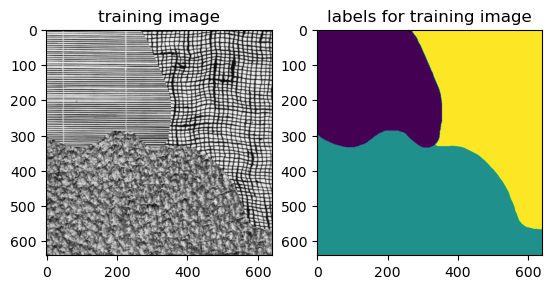

(640, 640) 409600


In [3]:
#%% READ IN IMAGES
training_image = skimage.io.imread(path + 'training_image.png')
training_image = training_image.astype(float)
training_labels = skimage.io.imread(path + 'training_labels.png')

training_labels = ind2labels(training_labels)
nr_labels = np.max(training_labels)+1 # number of labels in the training image

fig, ax = plt.subplots(1,2)
ax[0].imshow(training_image, cmap=plt.cm.gray)
ax[0].set_title('training image')
ax[1].imshow(training_labels)
ax[1].set_title('labels for training image')
plt.show()

print(training_image.shape, training_image.shape[0]*training_image.shape[1])

In [4]:
nr_labels

3

## (A) Compute features

In [5]:
#%% TRAING THE MODEL

In [6]:
# Compute the features
sigma = [1,2,3]
features = lf.get_gauss_feat_multi(training_image, sigma)
print(features.shape)

(409600, 3, 15)


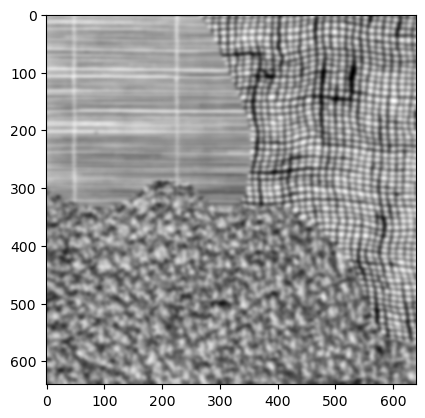

In [7]:
# look at the features
f = features[:,2,0].reshape((640,640))
plt.imshow(f,'gray')
plt.show()

In [8]:
# reshape features such as each row is a feature vector
features = features.reshape((features.shape[0], features.shape[1]*features.shape[2]))
print(features.shape)

(409600, 45)


## (B) Prepare labels for clustering

In [9]:
labels = training_labels.ravel()
labels.shape

(409600,)

In [10]:
labels.shape

(409600,)

## (C) Build dictionary

Using
all feature vectors for building the dictionary is very time consuming,
and it is sufficient to select a random subset of features.

In [22]:
# Select a random subset of feature vectors with corresponding labels

nr_keep = 15000 # number of features randomly picked for clustering 
keep_indices = np.random.permutation(np.arange(features.shape[0]))[:nr_keep] 

features_subset = features[keep_indices,:] # random subset of features
labels_subset = labels[keep_indices] # corresponding labels

In [23]:
# Use k -means to cluster the feature vectors into a number of clusters.

nr_clusters = 1000 # number of feature clusters
# for speed, I use mini-batches
kmeans = sklearn.cluster.MiniBatchKMeans(n_clusters=nr_clusters, batch_size=2*nr_clusters)
kmeans.fit(features_subset)
assignment = kmeans.labels_ # cluster_label of each pixel from the subset
print(assignment.shape)

(15000,)


In [24]:
assignment

array([925, 251, 977, ..., 594, 690, 291], dtype=int32)

In [25]:
# Compute the probability of a cluster belonging to each of the labels using Eq. 3.2 and 3.3, and store the probabilities in the array.

edges = np.arange(nr_clusters+1)-0.5 # histogram edges halfway between integers
hist = np.zeros((nr_clusters,nr_labels))
for l in range(nr_labels):
    hist[:,l] = np.histogram(assignment[labels_subset==l],bins=edges)[0] # for all pixel from the subset, get the cluster repartition for a given label
sum_hist = np.sum(hist,axis=1) # sum in horizontal direction => get cluster repartition for all all pixel from the subset (do not depend on label)
cluster_probabilities = hist/(sum_hist.reshape(-1,1))


/var/folders/94/9f_yx4cn1v33rqm4shxsd2jc0000gn/T/ipykernel_85166/846760200.py:8: RuntimeWarning: invalid value encountered in true_divide
  cluster_probabilities = hist/(sum_hist.reshape(-1,1))


Text(0.5, 1.0, 'cluster probabilities')

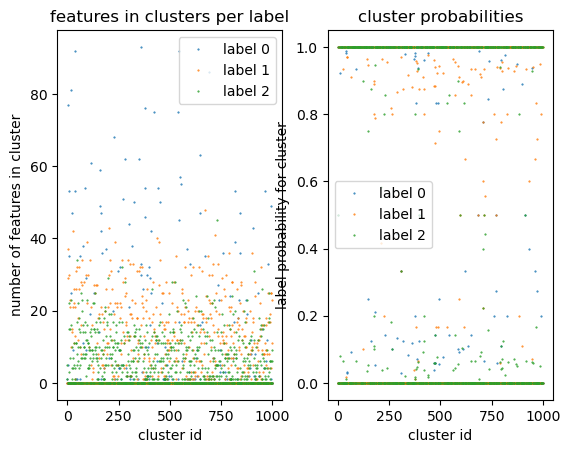

In [15]:
fig, ax = plt.subplots(1,2)
legend_label = [f'label {x}' for x in range(nr_labels)]

ax[0].plot(hist,'.', markersize=1)
ax[0].set_xlabel('cluster id')
ax[0].set_ylabel('number of features in cluster')
ax[0].legend(legend_label)
ax[0].set_title('features in clusters per label')
ax[1].plot(cluster_probabilities,'.', markersize=1)
ax[1].set_xlabel('cluster id')
ax[1].set_ylabel('label probability for cluster')
ax[1].legend(legend_label)
ax[1].set_title('cluster probabilities')

In [16]:
# Finished training

## (D) Assign dictionary to test image

In [17]:
#%% USING THE MODEL

In [18]:
# Compute a feature image from the test image
testing_image = skimage.io.imread(path + 'testing_image.png')
testing_image = testing_image.astype(float)

features_testing = lf.get_gauss_feat_multi(testing_image, sigma)
features_testing = features_testing.reshape((features_testing.shape[0], features_testing.shape[1]*features_testing.shape[2]))
print(testing_image.shape)

labels = training_labels.ravel()
print(labels.shape)

(640, 640)
(409600,)


In [19]:
# Use a nearest neighbor algorithm and find the nearest cluster for each feature in the image.
assignment_testing = kmeans.predict(features_testing) # Store the index of the nearest cluster center in an image of size r * c .
print(assignment_testing.shape)

(409600,)


In [77]:
assignment_testing

array([112, 647, 647, ..., 826, 826, 681], dtype=int32)

## (E) Compute probability image and segmentation

In [87]:
probability_image = np.zeros((assignment_testing.size, nr_labels)) # create probability image.

# In each pixel you insert the probability of the cluster center
for l in range(nr_labels):
    probability_image[:,l] = cluster_probabilities[assignment_testing, l]
probability_image = probability_image.reshape(testing_image.shape + (nr_labels,))
print(probability_image.shape)

(640, 640, 3)


In [20]:
assignment_testing.shape

(409600,)

In [85]:
# Obtain a segmentation by selecting the most probable label in each pixel.
P_rgb = np.zeros(probability_image.shape[0:2]+(3,))
print(P_rgb.shape)
k = min(nr_labels,3)
P_rgb[:,:,:k] = probability_image[:,:,:k] # just a copy (the probabilities are the rgb coefficient)

c = np.eye(P_rgb.shape[2])
seg_im_max = np.argmax(P_rgb,axis = 2)
P_rgb_max = c[seg_im_max] # segmented im with rgb values like 1 0 0 or 0 1 0 or 0 0 1

(640, 640, 3)


Text(0.5, 1.0, 'probabilities for testing image as RGB')

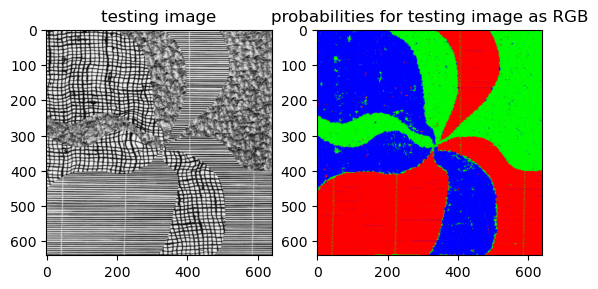

In [83]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(testing_image, cmap=plt.cm.gray)
ax[0].set_title('testing image')
ax[1].imshow(P_rgb)
ax[1].set_title('probabilities for testing image as RGB')

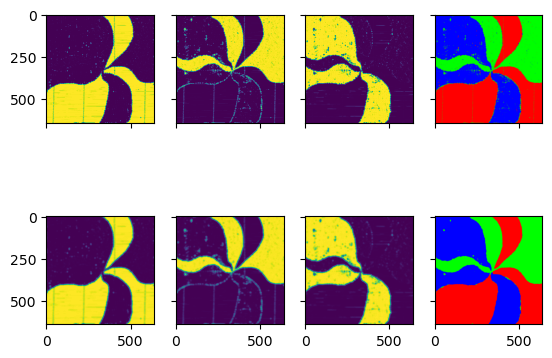

In [91]:
#%% SMOOTH PROBABILITY MAP
# smoothing the probability image before selecting the most probable label.

sigma = 3 # Gaussian smoothing parameter

c = np.eye(P_rgb.shape[2])

seg_im_max = np.argmax(P_rgb,axis = 2)
P_rgb_max = c[seg_im_max]

# smooth each layer of the probability image (each label)
probability_smooth = np.zeros(probability_image.shape)
for i in range(0,probability_image.shape[2]):
    probability_smooth[:,:,i] = scipy.ndimage.gaussian_filter(probability_image[:,:,i],sigma,order=0)
    
seg_im_smooth = np.argmax(probability_smooth,axis=2)
probability_smooth_max = c[seg_im_smooth]

P_rgb_smooth = np.zeros(probability_smooth_max.shape[0:2]+(3,))
k = min(nr_labels,3)
P_rgb_smooth[:,:,:k] = probability_smooth[:,:,:k]
P_rgb_smooth_max = np.zeros(probability_smooth_max.shape[0:2]+(3,))
P_rgb_smooth_max[:,:,:k] = probability_smooth_max[:,:,:k]

# Display result
fig,ax = plt.subplots(2,4,sharex=True,sharey=True)
ax[0][0].imshow(P_rgb[:,:,0])
ax[0][1].imshow(P_rgb[:,:,1])
ax[0][2].imshow(P_rgb[:,:,2])
ax[0][3].imshow(P_rgb_max)
ax[1][0].imshow(P_rgb_smooth[:,:,0])
ax[1][1].imshow(P_rgb_smooth[:,:,1])
ax[1][2].imshow(P_rgb_smooth[:,:,2])
ax[1][3].imshow(P_rgb_smooth_max)
plt.show()